In [1]:
from matplotlib import pyplot as plt
import numpy as np

import os
import PIL

import random

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

if torch.cuda.is_available():
  print("Using GPU!")
  device = torch.device("cuda")
else:
  print("Using CPU")
  device = torch.device("cpu")

Using GPU!


In [37]:
expanded_dataset = False
path = "_2" if expanded_dataset else ""

In [25]:
def get_all_types():
    with open('pokemon_data/pokemon' + path + '.csv', 'r') as pokemon_list:
        types = set()
        
        for line in pokemon_list:
            types.update(set(line.strip().split(',')[1:]))
            
        types.difference_update(['', 'Type1', 'Type2'])
        
    return list(types)

In [26]:
def get_all_data(_type_to_id, _num_types):
    with open('pokemon_data/pokemon' + path + '.csv','r') as pokemon_list:
        output = []
        for line in list(pokemon_list)[1:]: 
            csv_data = line.strip().split(',')
            
            y = torch.zeros(_num_types)
            for types in csv_data[1:]:
                if types != '':
                    y[_type_to_id[types]] = 1
                    
            output.append((csv_data[0], y))
            
    return output[1:]

In [45]:
batch_size = 20

types = get_all_types()
num_types = len(types)
id_to_type = {i: val for i, val in enumerate(types)}
type_to_id = {val: i for i, val in enumerate(types)}

all_data = get_all_data(type_to_id, num_types)
random.shuffle(all_data)
image_list, type_list = list(zip(*all_data))

image_batch, type_batch = [], []
for i in range(0, len(image_list), batch_size):
    image_batch.append(image_list[i:i+batch_size])
    type_batch.append(type_list[i:i+batch_size])

split1 = round(len(image_batch) * .6)
split2 = split1 + round(len(image_batch) * .2)
train_image, train_type = image_batch[:split1], type_batch[:split1]
test_image, test_type = image_batch[split1:split2], type_batch[split1:split2]
dev_image, dev_type = image_batch[split2:], type_batch[split2:]

num_epochs = 5

In [27]:
def get_image(image_names):
    images = []
    for image_name in image_names:
        image = PIL.Image.open(os.path.join('pokemon_data/images' + path, image_name+'.png'))
        if len(image.size) == 2:
            image = image.convert('RGBA')
        images.append(torch.tensor(np.transpose(np.asarray(image.resize((120,120))) / 255.0, (2, 0, 1)))
                      .float()[:3,:,:])
    
    return torch.stack(images)

In [ ]:
class PokemonModel(nn.Module):
    def __init__(self):
        super(PokemonModel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 128, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Conv2d(128, 256, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(4)
        )
        self.lin = nn.Sequential(
            nn.Linear(256, num_types),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        cnn = self.main(x)
        cnn_flat = torch.reshape(cnn, [-1, 256])
        out = self.lin(cnn_flat)
        
        return out        

In [ ]:
model = models.vgg16(pretrained=True)

# Freeze all layers
for p in model.parameters():
    p.requires_grad = False

# Define new classifier layer. This layer will not be frozen
new_classifier = nn.Sequential(
                    nn.Linear(25088, num_types, bias=True),
                    nn.Sigmoid()
                )

model._modules['classifier'] = new_classifier

model.to(device)

In [73]:
# model = PokemonModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    for x, y in tqdm(zip(train_image, train_type)):
        img_x = get_image(x).reshape((-1, 3, 120, 120)).to(device)
        img_y = torch.stack(y).to(device)
        model.zero_grad()
        
        output = model.forward(img_x)
        loss = criterion(output, img_y)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        loss = 0
        for x, y in zip(dev_image, dev_type):
            img_x = get_image(x).reshape((-1, 3, 120, 120)).to(device)
            img_y = torch.stack(y).to(device)
            output = model.forward(img_x)
            loss += criterion(output, img_y)
            
        print("Epoch:", epoch+1, "Dev Loss:", loss.item())

23it [01:06,  2.89s/it]


Epoch: 1 Dev Loss: 28.94965934753418


23it [01:18,  3.42s/it]


Epoch: 2 Dev Loss: 28.50078773498535


23it [01:31,  3.96s/it]


Epoch: 3 Dev Loss: 28.271095275878906


23it [01:31,  3.96s/it]


Epoch: 4 Dev Loss: 28.095481872558594


23it [01:31,  3.96s/it]


Epoch: 5 Dev Loss: 27.988183975219727


23it [01:31,  3.96s/it]


Epoch: 6 Dev Loss: 27.921533584594727


23it [01:31,  3.96s/it]


Epoch: 7 Dev Loss: 27.877859115600586


23it [01:31,  3.96s/it]


Epoch: 8 Dev Loss: 27.847637176513672


In [74]:
# Test data

correct_ct = 0
test_image_flat = [i for batch in test_image for i in batch]
test_type_flat = [i for batch in test_type for i in batch]
for x, y in tqdm(zip(test_image_flat, test_type_flat)):
    with torch.no_grad():
        img_x = get_image([x]).reshape((-1, 3, 120, 120)).to(device)
        img_y = y.to(device)
        
        output = model.forward(img_x)            
        v, i = output.topk(2)
        type1 = i.squeeze()[0].item()
        type2 = i.squeeze()[1].item() if v.squeeze()[1] > 0.8 else None
        
        if y[type1] == 1:
#             if (type2 and y[type2] == 1) or not type2:
            correct_ct += 1
#                 print(x, id_to_type[type1], id_to_type[type2] if type2 else None)
            
print("Accuracy", correct_ct/len(test_image_flat))

1600it [00:52, 30.37it/s]

Accuracy 0.5825


In [53]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 120, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120, 120 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 2, 120 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 4, 120 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(120 * 8, 1, 4, 4, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        cnn = self.main(input)
        return cnn

d = Discriminator().to(device)
d_optimizer = optim.Adam(d.parameters(), lr=1e-4)

In [54]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 120 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(120 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(120 * 8, 120 * 4, 8, 3, 1, bias=False),
            nn.BatchNorm2d(120 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(120 * 4, 120 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(120 * 2, 120, 4, 2, 1, bias=False),
            nn.BatchNorm2d(120),
            nn.ReLU(True),
            nn.ConvTranspose2d(120, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

g = Generator().to(device)
g_optimizer = optim.Adam(g.parameters(), lr=3e-3)

In [55]:
def train_discriminator(x):
  d_optimizer.zero_grad()

  real_output = d.forward(x)
  real_y = torch.zeros(real_output.shape[0]).to(device)
  real_loss = nn.BCELoss()(real_output.squeeze(), real_y)
  
  noise = torch.randn(batch_size, 100, 1, 1).to(device)
  fake_x = g.forward(noise)

  gen_output = d.forward(fake_x)
  gen_y = torch.ones(fake_x.shape[0]).to(device)
  gen_loss = nn.BCELoss()(gen_output.squeeze(), gen_y)

  total_loss = real_loss + gen_loss
  total_loss.backward()
  d_optimizer.step()

  return total_loss

In [56]:
def train_generator():
    g_optimizer.zero_grad()
    
    # Generate fake data
    noise = torch.randn(batch_size, 100, 1, 1).to(device)
    fake_x = g.forward(noise)
    
    # Test against the discriminator
    disc_output = d.forward(fake_x)
    targets = torch.zeros(fake_x.shape[0]).to(device) # We want the discriminator to think these images are real.
    loss = nn.BCELoss()(disc_output.squeeze(), targets) # How well did the generator do? (How much did the discriminator believe the generator?)
    
    # Update the generator based on how well it fooled the discriminator
    loss.backward()
    g_optimizer.step()

    return loss

In [57]:
# Real = 0, Fake = 1
for epoch in range(num_epochs):
  d_loss = 0
  g_loss = 0
  for x, y in tqdm(zip(train_image, train_type)):
    img_x = get_image(x).reshape((-1, 3, 120, 120)).to(device)
    img_y = torch.stack(y).to(device)
    
    d_loss += train_discriminator(img_x)
    g_loss += train_generator()
        
            
  print("Epoch:", epoch+1, "Disc Loss:", d_loss.item(), "Gen Loss:", g_loss.item())

  noise = torch.randn(batch_size, 100, 1, 1).to(device)
  fake_x = g.forward(noise)
  plt.imshow(fake_x.cpu().detach()[0].permute((1, 2, 0)))

27it [00:27,  1.01s/it]


Epoch: 1 Disc Loss: 10.731867790222168 Gen Loss: 193.73106384277344


27it [00:27,  1.01s/it]


Epoch: 2 Disc Loss: 1.541774034500122 Gen Loss: 225.93576049804688


27it [00:27,  1.01s/it]


Epoch: 3 Disc Loss: 0.3010260760784149 Gen Loss: 190.53416442871094


27it [00:27,  1.01s/it]


Epoch: 4 Disc Loss: 0.1686663180589676 Gen Loss: 189.693603515625


27it [00:27,  1.01s/it]


Epoch: 5 Disc Loss: 0.1389176845550537 Gen Loss: 190.3134765625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


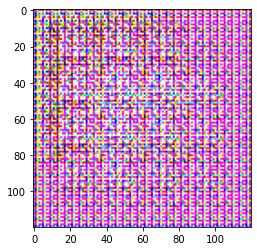

In [58]:
noise = torch.randn(batch_size, 100, 1, 1).to(device)
fake_x = g.forward(noise)
plt.imshow(fake_x.cpu().detach()[0].permute((1, 2, 0)))